In this article we create several truthsets based on various models of alternative allele frequency distribution.  To each truthset corresponds a family of callsets.  Given a truthset and a callset family we can evaluate the performance of individual callers and of VariantMetaCaller.  The performance is expressed in terms of precision and recall.  Both the truthsets and the callsets are based on the benchmark data.  Each truthset (and family of callsets) belongs to a combination of (1) a specific exponential model of AAF distribution, (2) variant type and (3) sample and region.

In [144]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import attila_utils
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
from IPython.display import set_matplotlib_formats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import truth_sets_aaf as tsa
import pandas as pd
import multi_prec_recall as multipr
import seaborn

Read in model parameters into `expm` for all combinations and create a truthset for each combination storing the names of output VCFs in `outvcfs`.

In [3]:
expm = pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/exp_model.csv',
                   dtype={'lambda': 'category', 'region': 'category', 'sample': 'category', 'vartype': 'category', 'log10s2g': 'category'})

In [4]:
#outvcfs = tsa.downsample_absolutely_all_vcfs(expm, topdir='/home/attila/projects/bsm/results/2019-03-18-truth-sets', seed=19760415)
#pd.DataFrame({'outvcf': outvcfs}).to_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv', index=False)

Let's write the pathnames for the resulting truthset VCFs to a CSV file!

In [5]:
outvcfs = list(pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv')['outvcf'])

The operation below does the following
1. prepare (filter) callsets at each combination of region and variant type
1. reduce callsets by removing nonvariants defined by the exponential model for all parameter combinations (log10s2g, lambda, sample)
1. calculate precision and recall for all those conditions

In [6]:
#pr = multipr.run_all()
#pr.to_csv('/home/attila/projects/bsm/results/2019-05-02-make-truth-sets/pr.csv', index=False)

Reloading saved precision--recall data

In [7]:
pr = multipr.read_pr_csv('/home/attila/projects/bsm/results/2019-05-02-make-truth-sets/pr.csv')
vmcbn = '/big/results/bsm/2018-06-22-variant-meta-caller-test/vmc-prioritize-benchmark/'
vmc_pr_chr22_thinks = multipr.vmc_prepare_reduce_precrecall(csetVCF=vmcbn + 'test12/vmc-test12.vcf.gz', region='chr22', vartype='snp', machine='ThinkS')
vmc_pr_chr22_ada = multipr.vmc_prepare_reduce_precrecall(csetVCF=vmcbn + 'test14ada/vmc-test14ada.vcf.gz', region='chr22', vartype='snp', machine='Ada')
vmc_pr_chr1_2_ada = multipr.vmc_prepare_reduce_precrecall(csetVCF=vmcbn + 'test17ada/vmc-test17ada.vcf.gz', region='chr1_2', vartype='snp', machine='Ada')
vmc_pr_chr22 = pd.concat([vmc_pr_chr22_thinks, vmc_pr_chr22_ada])

## Results

### Running VariantMetaCaller

The following result shows that VariantMetaCaller didn't run on the entire input data that correspond to chr1 + chr2.  It exited somewhere arund the third of chr1.

In [8]:
%%bash
cd ~/data/refgenome/GRCh37/dna
echo Lenght of chr1 and chr2
head -n2 hs37d5.fa.fai | cut -f1-2
echo -e '\nLast positions in the output of VariantMetaCaller'
cd /home/attila/projects/bsm/results/2018-06-22-variant-meta-caller-test/vmc-prioritize-benchmark/test17ada/
bcftools view results.vcf 2> /dev/null | tail -n5 | cut -f1-2

Lenght of chr1 and chr2
1	249250621
2	243199373

Last positions in the output of VariantMetaCaller
1	86682154
1	86682202
1	86682251
1	86682277
1	86682278


We remedy this by correcting the recall with the `correct_vmc_pr` function that uses a correction factor `corr_f` calculated from the chromosome lengths and the lenght of the segment processed by VariantMetaCaller.

In [9]:
vmc_pr_ada = pd.concat([vmc_pr_chr22_ada,
                        multipr.correct_vmc_pr(vmc_pr_chr1_2_ada, corr_f=(249250621 + 243199373) / 86682278)])

Finally, let's get the length of chr22!  This will be useful for comparing runtimes.

In [10]:
%%bash
cd ~/data/refgenome/GRCh37/dna
echo Lenght of chr22
head -n22 hs37d5.fa.fai | tail -n1 | cut -f1-2

Lenght of chr22
22	51304566


In [11]:
fpath_basen = vmcbn + 'test'
d1 = {'fpath': fpath_basen + '12/runtime', 'region': 'chr22', 'machine': 'ThinkS'}
d2 = {'fpath': fpath_basen + '14ada/runtime', 'region': 'chr22', 'machine': 'Ada'}
d3 = {'fpath': fpath_basen + '17ada/runtime', 'region': 'chr1_2', 'machine': 'Ada'}
l = [multipr.read_runtime(**d) for d in [d1, d2, d3]]
runtimes = pd.concat(l)
runtimes.head()

,type,runtime,region,machine,region_length
0,real,9984.580,chr22,ThinkS,51304566
1,user,139438.360,chr22,ThinkS,51304566
2,sys,266.760,chr22,ThinkS,51304566
0,real,7318.377,chr22,Ada,51304566
1,user,177299.333,chr22,Ada,51304566


The plot shows that VariantMetaCaller's runtime scales supralinearly with the lenght of the genomic region (assumed to be proportional to the total number of calls).  This is consistent with [SVMs having quadratic complexity](https://www.quora.com/What-is-the-computational-complexity-of-an-SVM) (András Gézsi, personal communication).

['named-figure/vmc-runtime-scaling.png',
 'named-figure/vmc-runtime-scaling.pdf']

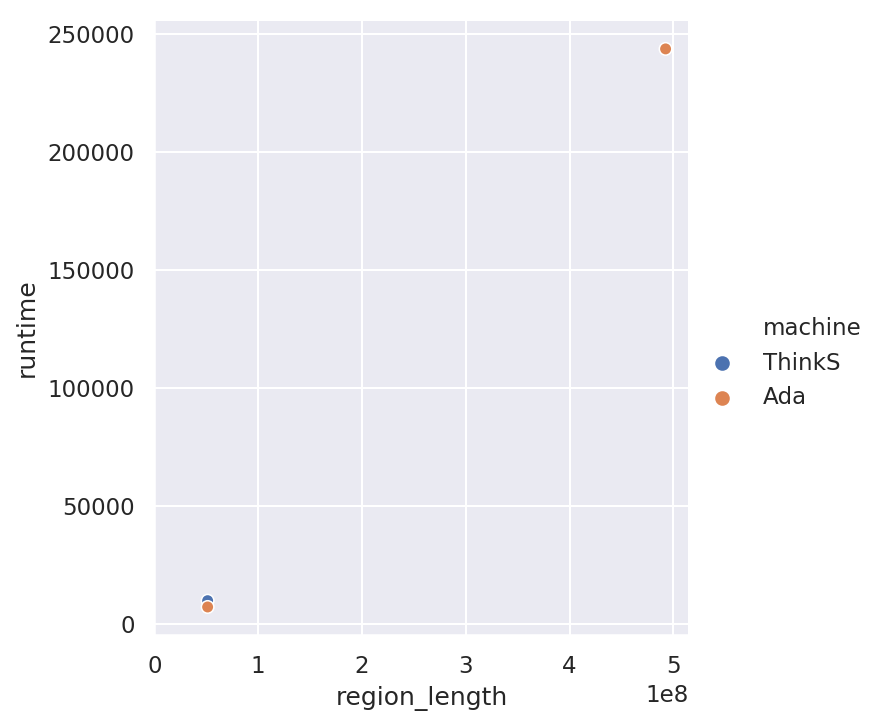

In [355]:
seaborn.set()
fg = seaborn.relplot(x='region_length', y='runtime', hue='machine', data=runtimes.loc[runtimes['type'] == 'real', :])
fg.axes[0][0].set_xlim(0, )
attila_utils.savefig(fg, 'vmc-runtime-scaling')

### SNVs

The plots below show
* *filled circles*: the precision-recall **points** of individual callers (the *callsets*) with their default `PASS` filter if that is available
* *solid black line*: the precision-recall **curve** of VariantMetaCaller (VMC) based on all those individual callers (when available)
* *dotted black line*: same as above but with precision estimated by VMC rather than the real precision

#### log10s2g = -2

['named-figure/prec-recall-snp-log10s2g-2.png',
 'named-figure/prec-recall-snp-log10s2g-2.pdf']

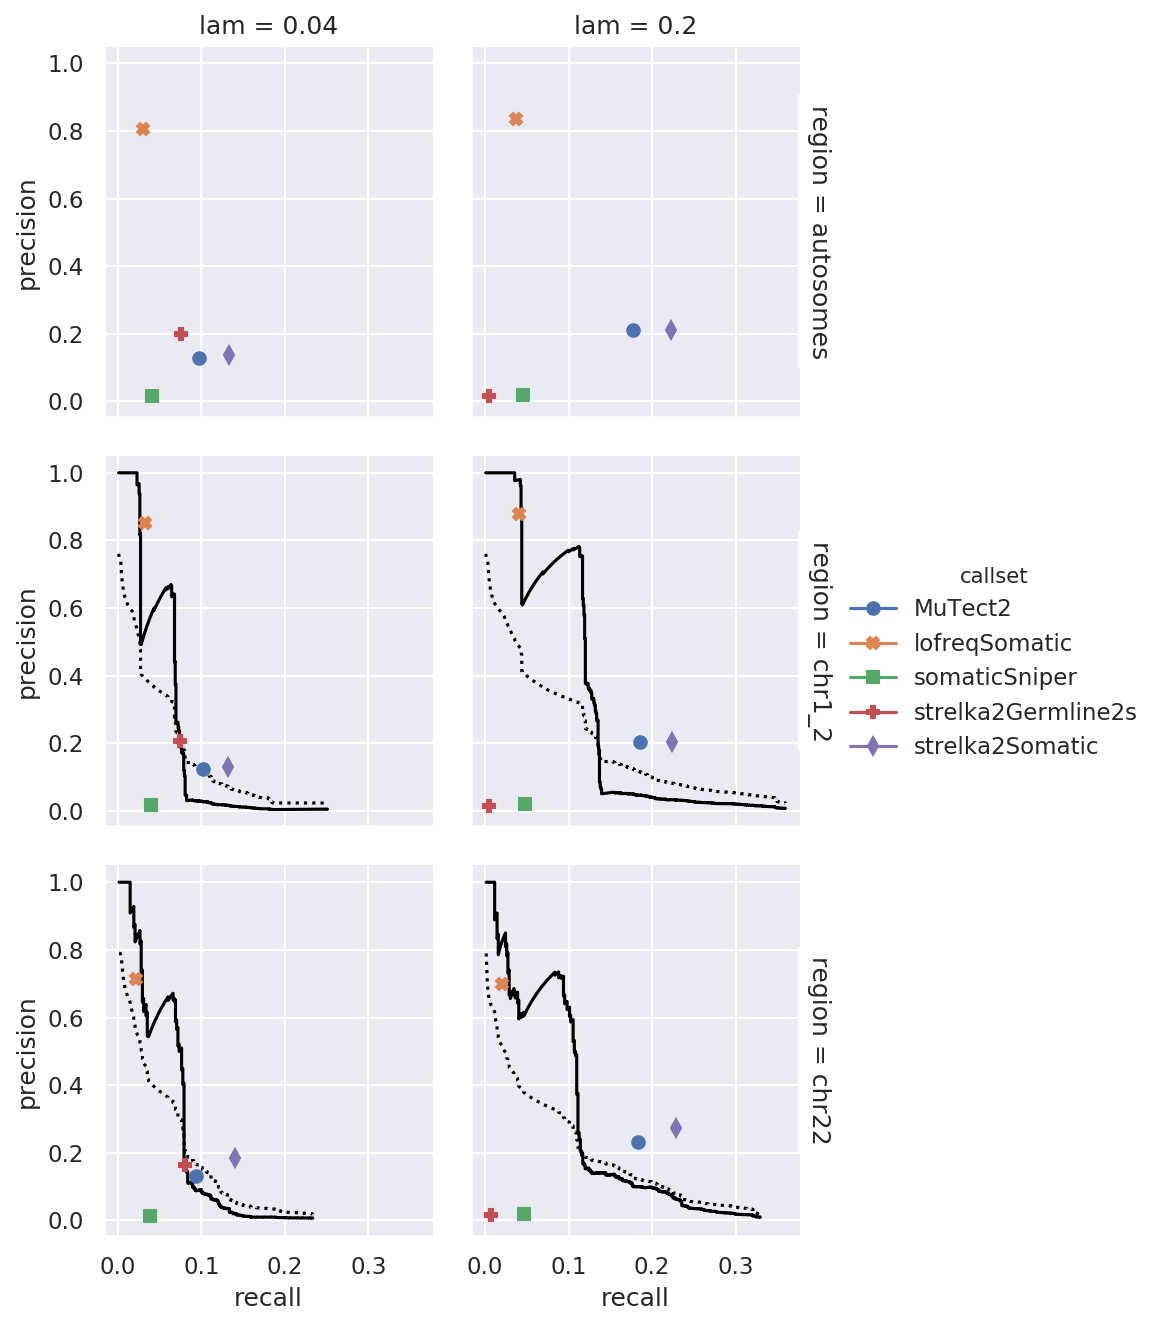

In [399]:
fg = multipr.plotter1(pr=pr, vmc_pr=vmc_pr_ada, sample='mix1', log10s2g=-2, vartype='snp')
attila_utils.savefig(fg, 'prec-recall-snp-log10s2g-2')

#### log10s2g = -3

['named-figure/prec-recall-snp-log10s2g-3.png',
 'named-figure/prec-recall-snp-log10s2g-3.pdf']

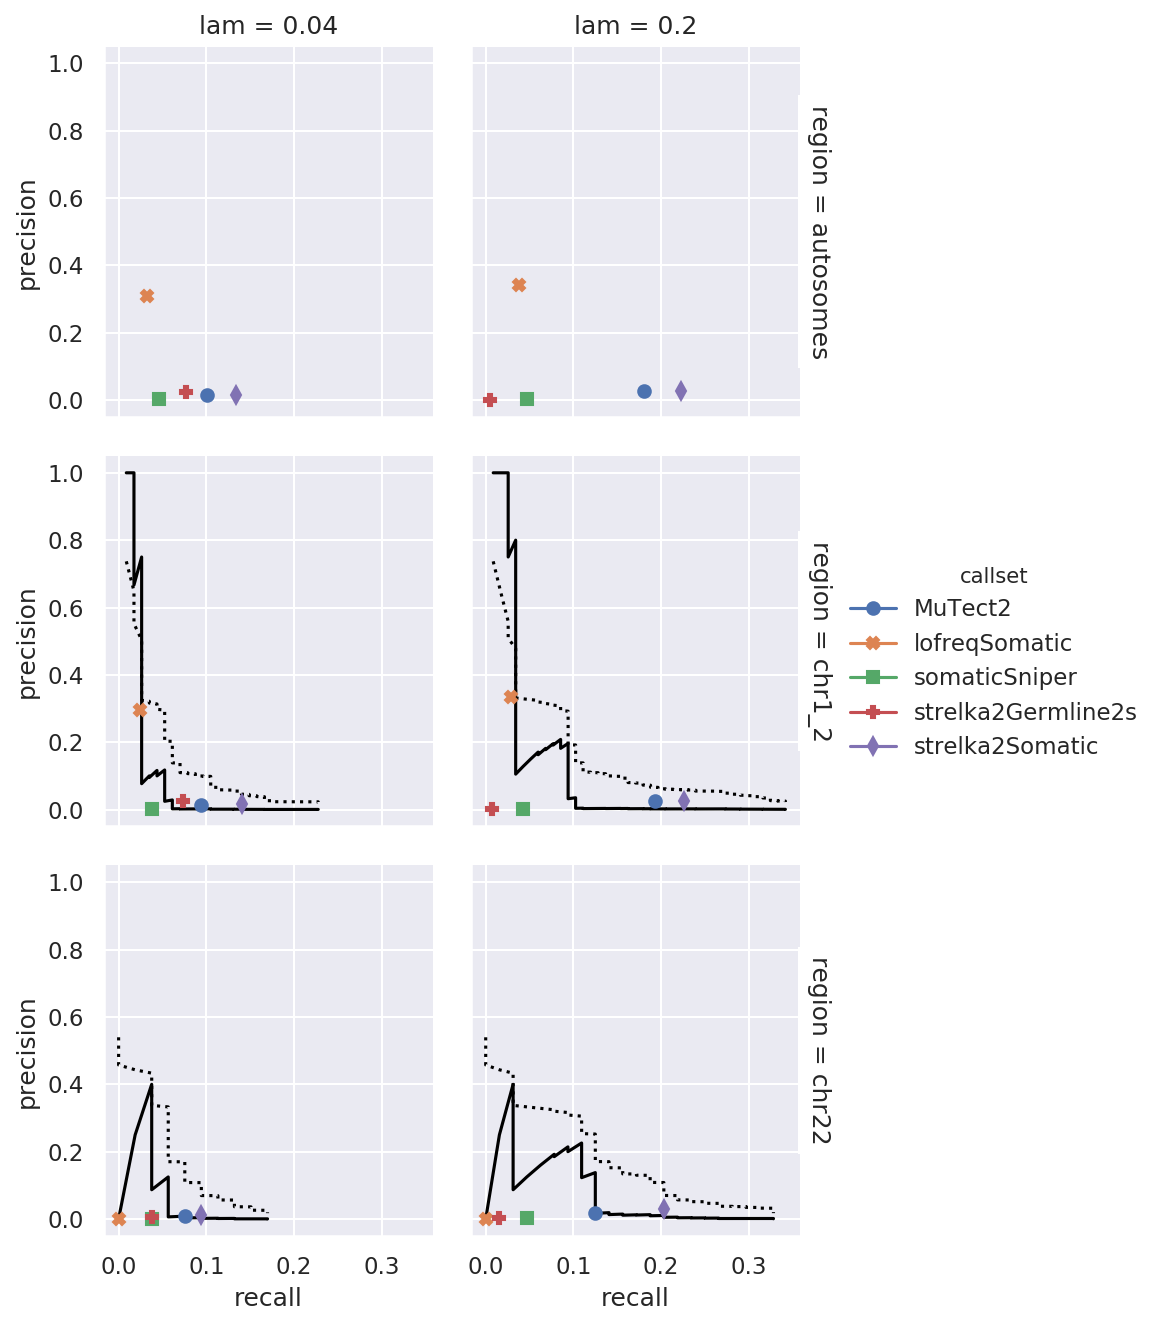

In [400]:
fg = multipr.plotter1(pr=pr, vmc_pr=vmc_pr_ada, sample='mix1', log10s2g=-3, vartype='snp')
attila_utils.savefig(fg, 'prec-recall-snp-log10s2g-3')

#### log10s2g = -4

['named-figure/prec-recall-snp-log10s2g-4.png',
 'named-figure/prec-recall-snp-log10s2g-4.pdf']

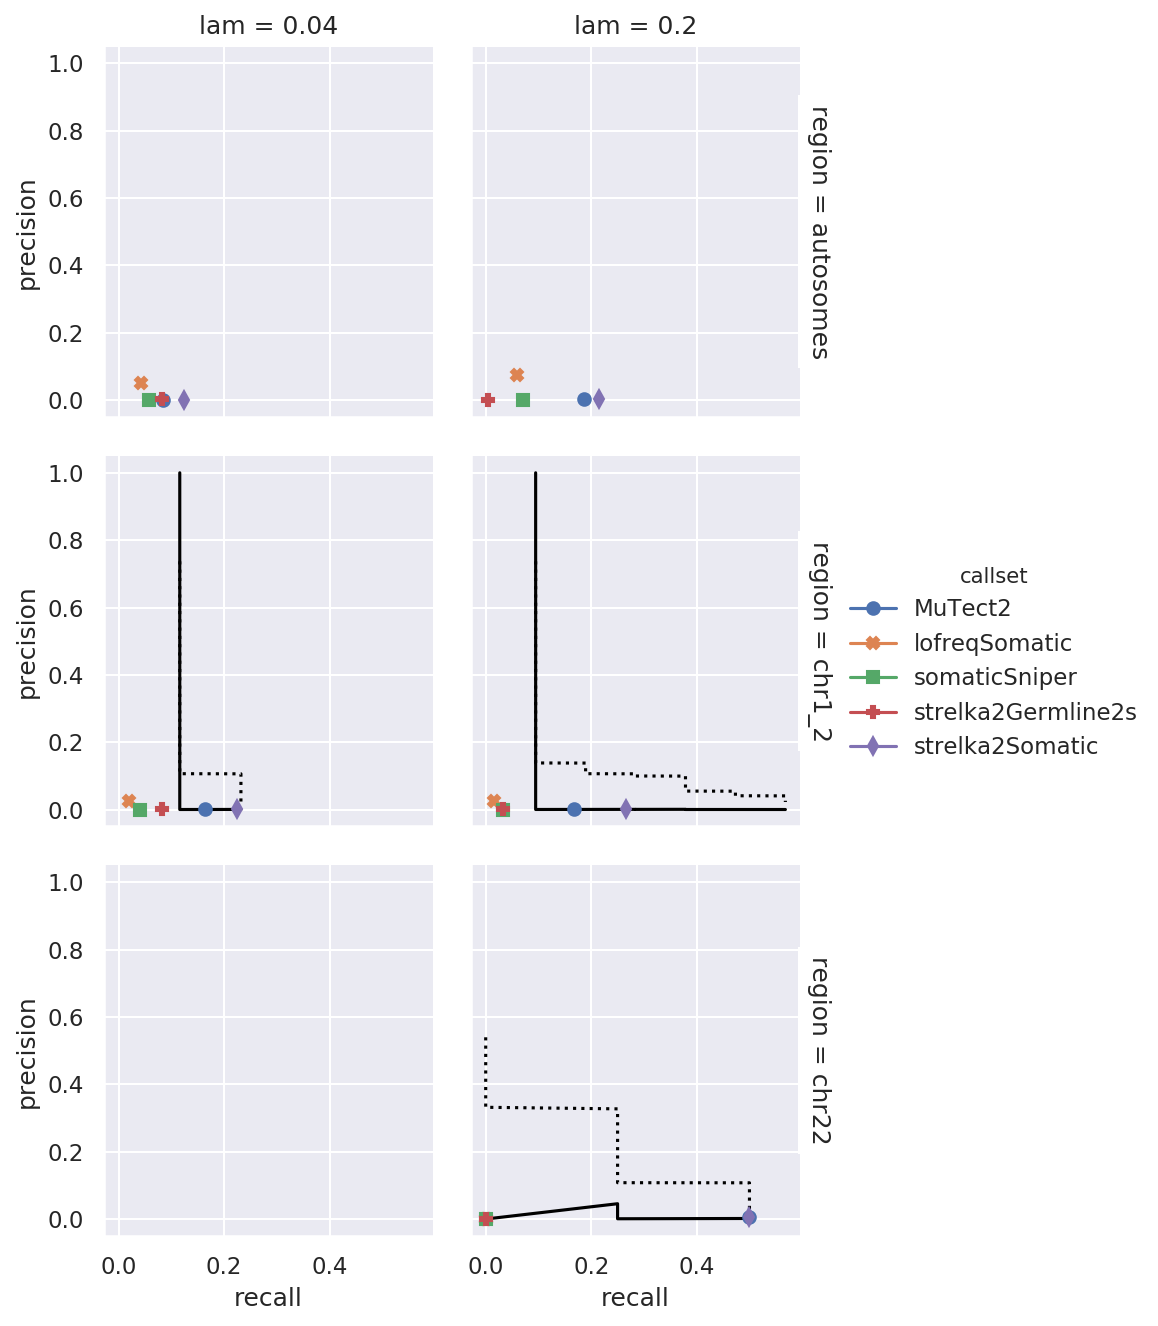

In [401]:
fg = multipr.plotter1(pr=pr, vmc_pr=vmc_pr_ada, sample='mix1', log10s2g=-4, vartype='snp')
attila_utils.savefig(fg, 'prec-recall-snp-log10s2g-4')

### Indels

#### log10s2g = -2

['named-figure/prec-recall-indel-log10s2g-2.png',
 'named-figure/prec-recall-indel-log10s2g-2.pdf']

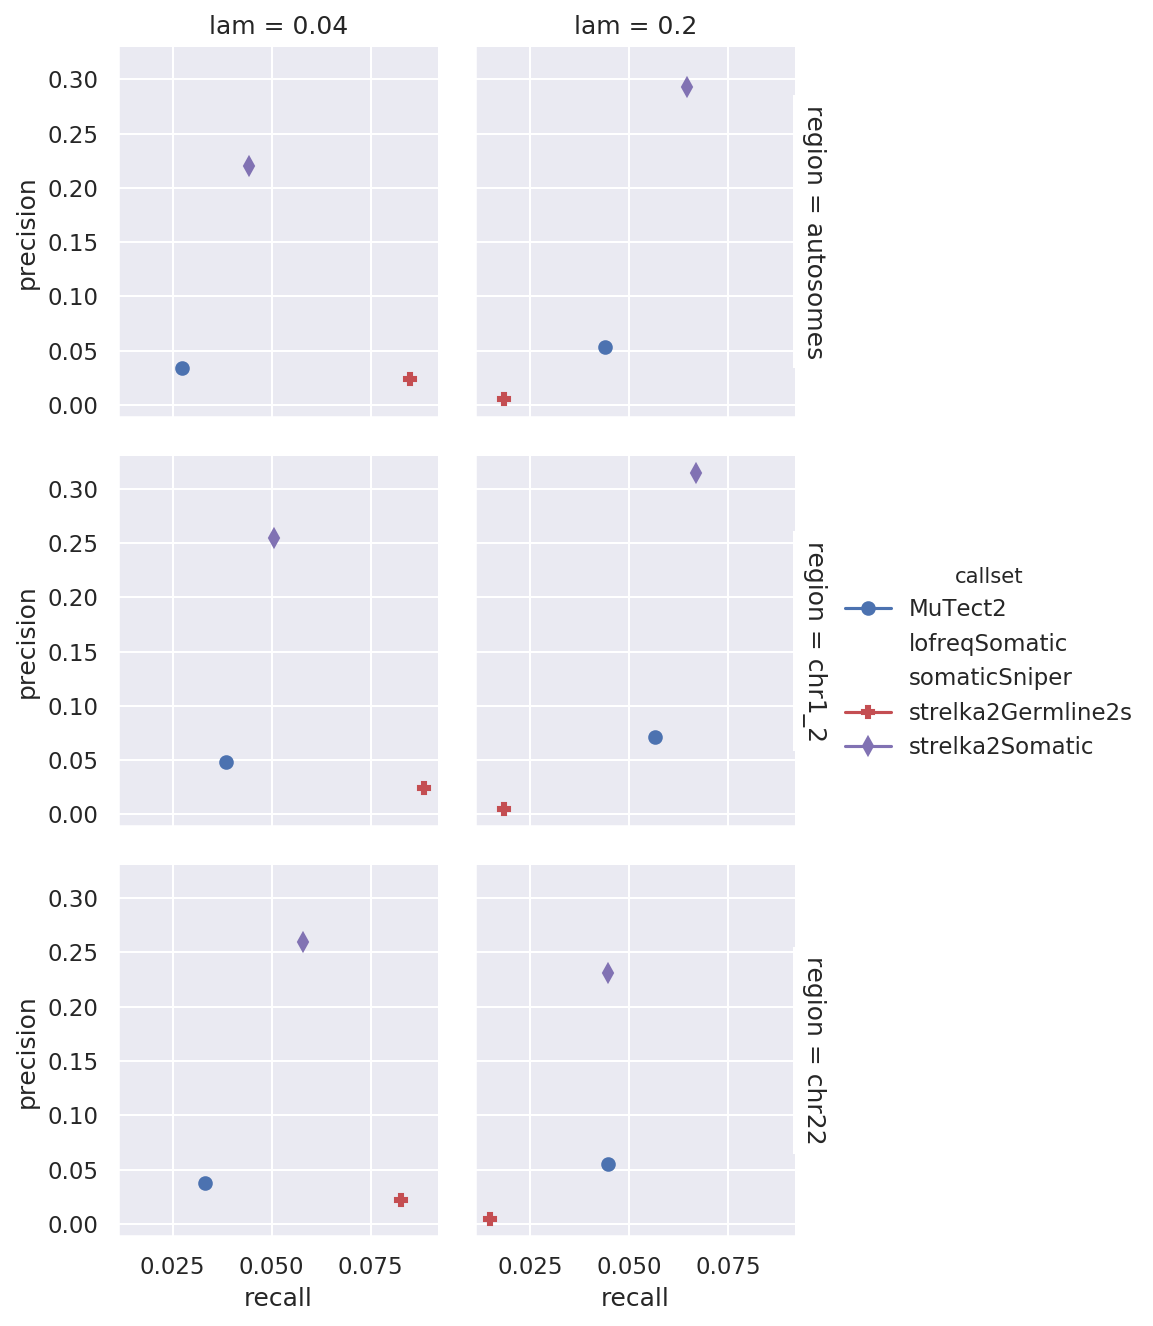

In [402]:
fg = multipr.plotter1(pr=pr, vmc_pr=None, sample='mix1', log10s2g=-2, vartype='indel')
attila_utils.savefig(fg, 'prec-recall-indel-log10s2g-2')

#### log10s2g = -3

['named-figure/prec-recall-indel-log10s2g-3.png',
 'named-figure/prec-recall-indel-log10s2g-3.pdf']

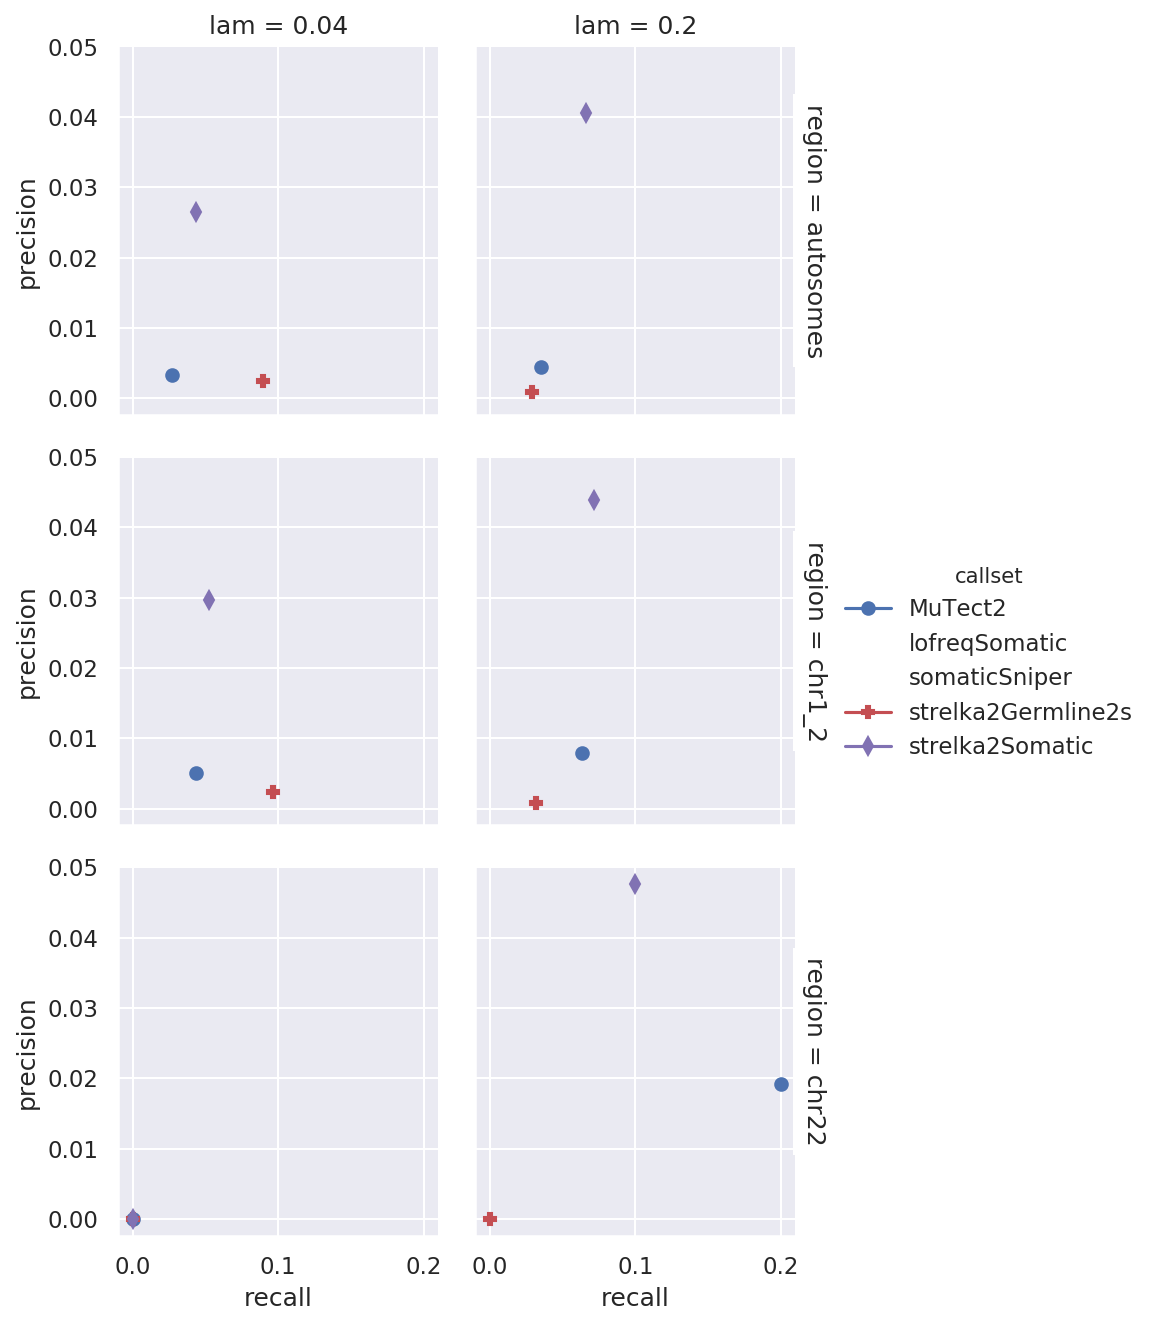

In [403]:
fg = multipr.plotter1(pr=pr, sample='mix1', log10s2g=-3, vartype='indel')
attila_utils.savefig(fg, 'prec-recall-indel-log10s2g-3')

#### log10s2g = -4

['named-figure/prec-recall-indel-log10s2g-4.png',
 'named-figure/prec-recall-indel-log10s2g-4.pdf']

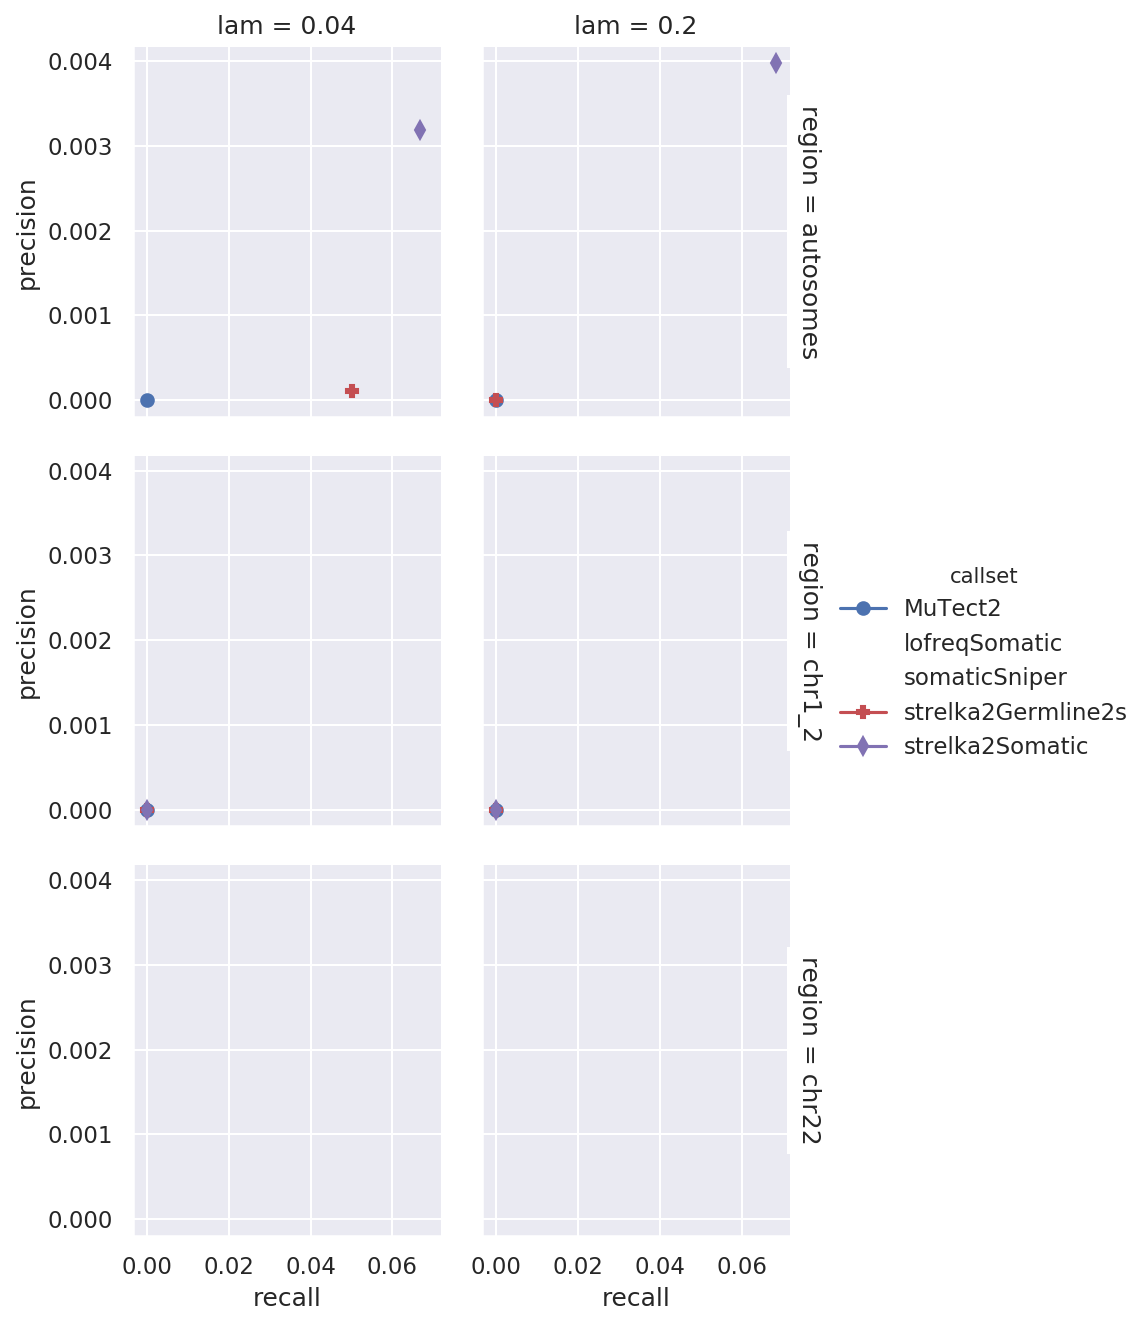

In [410]:
fg = multipr.plotter1(pr=pr, sample='mix1', log10s2g=-4, vartype='indel')
attila_utils.savefig(fg, 'prec-recall-indel-log10s2g-4')

### Other views

['named-figure/prec-recall-indel-region-autosomes.png',
 'named-figure/prec-recall-indel-region-autosomes.pdf']

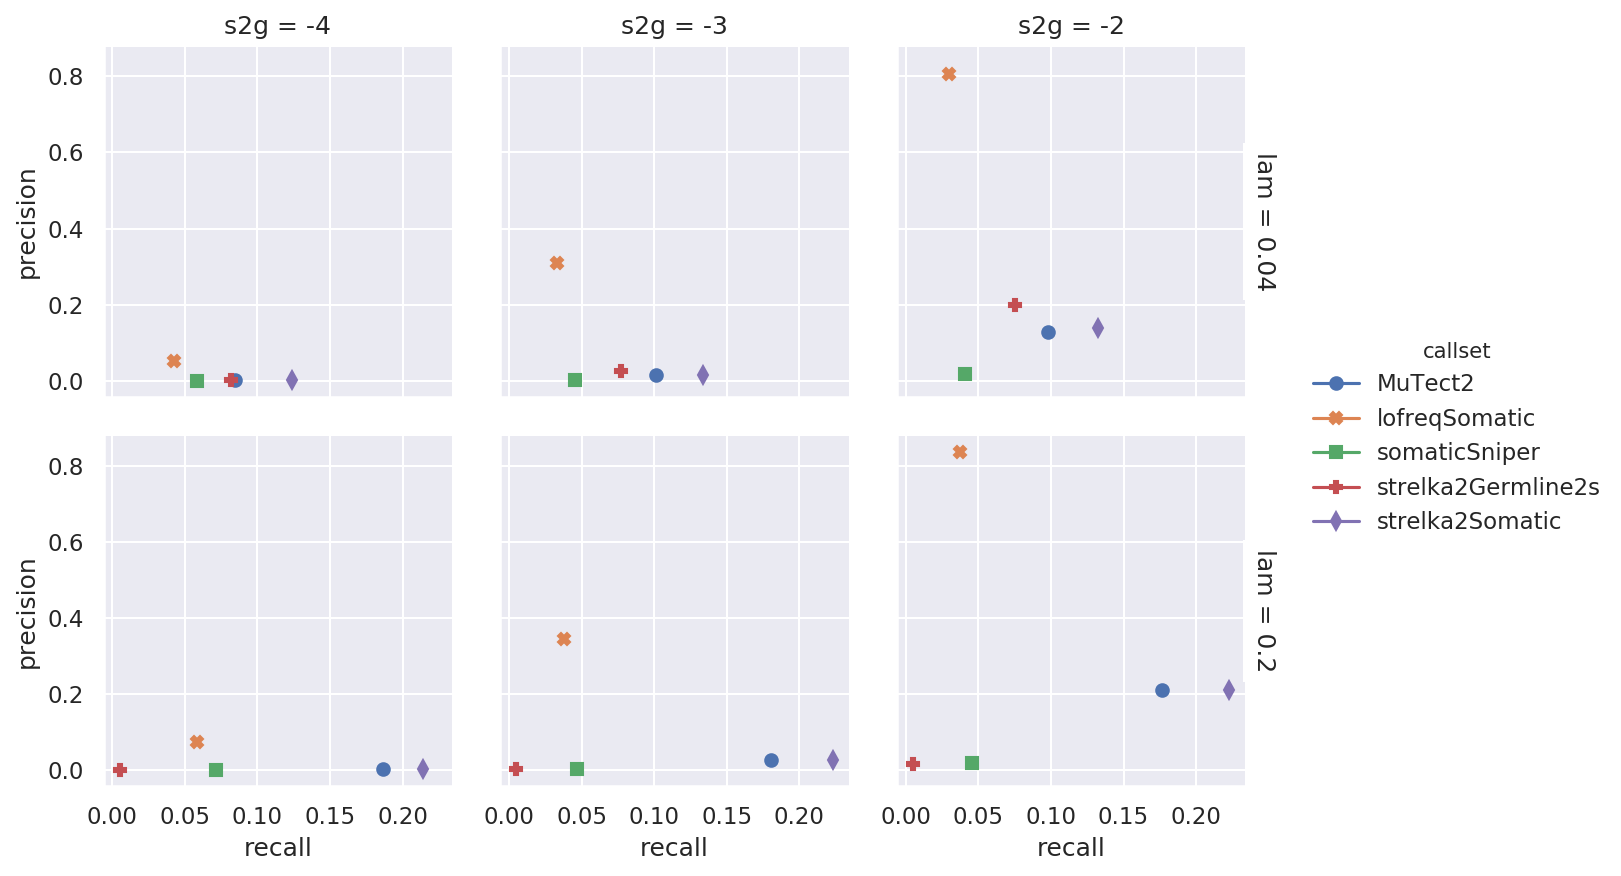

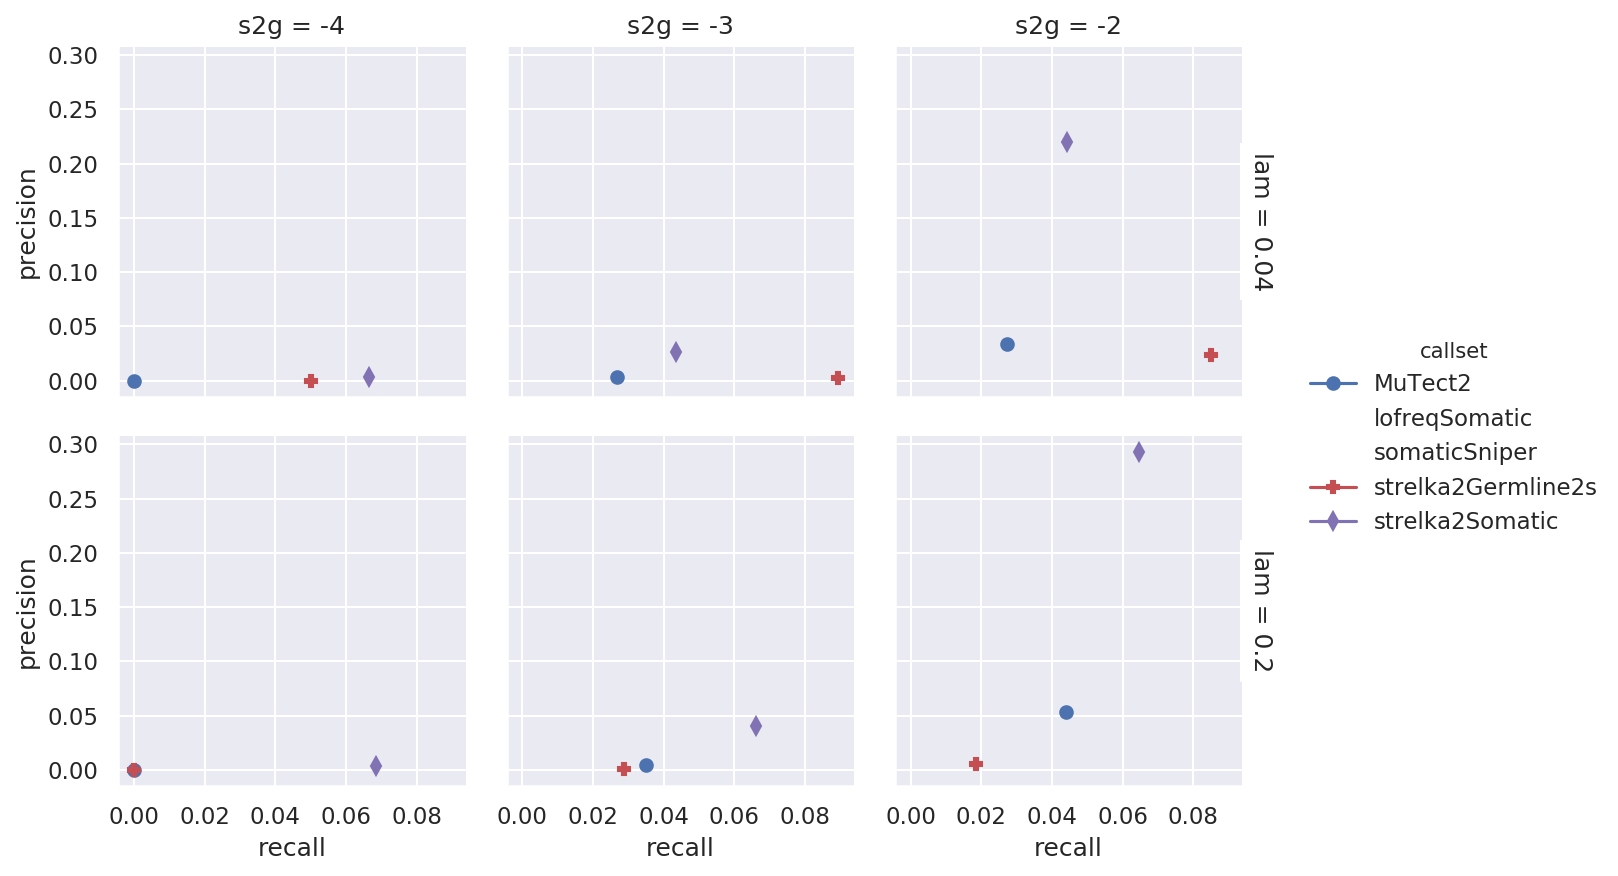

In [405]:
fg = multipr.plotter3(pr, vartype='snp')
attila_utils.savefig(fg, 'prec-recall-snp-region-autosomes')
fg = multipr.plotter3(pr, vartype='indel')
attila_utils.savefig(fg, 'prec-recall-indel-region-autosomes')

['named-figure/prec-recall-snp-lambda-02.png',
 'named-figure/prec-recall-snp-lambda-02.pdf']

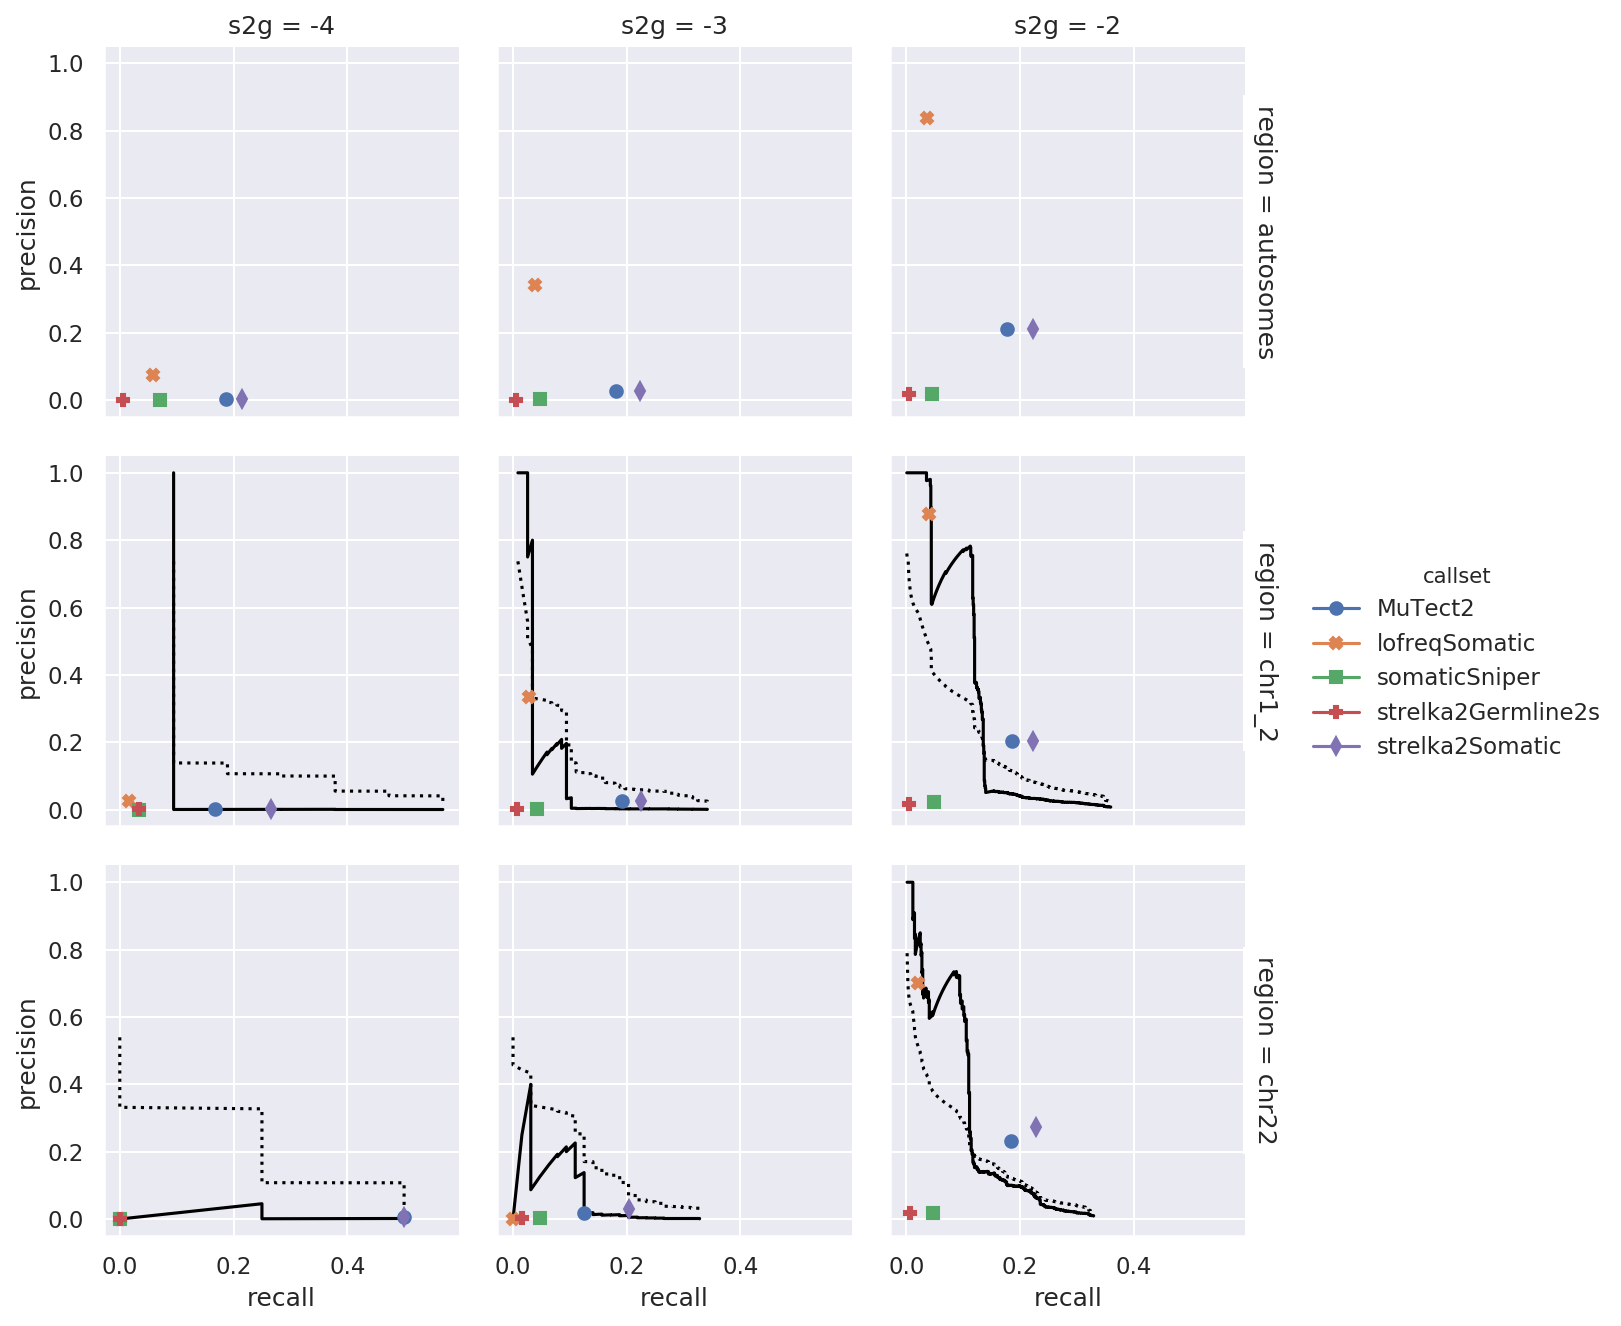

In [409]:
fg = multipr.plotter4(pr, vmc_pr_ada, vartype='snp')
attila_utils.savefig(fg, 'prec-recall-snp-lambda-02')

### Comparing VMC results with different machines

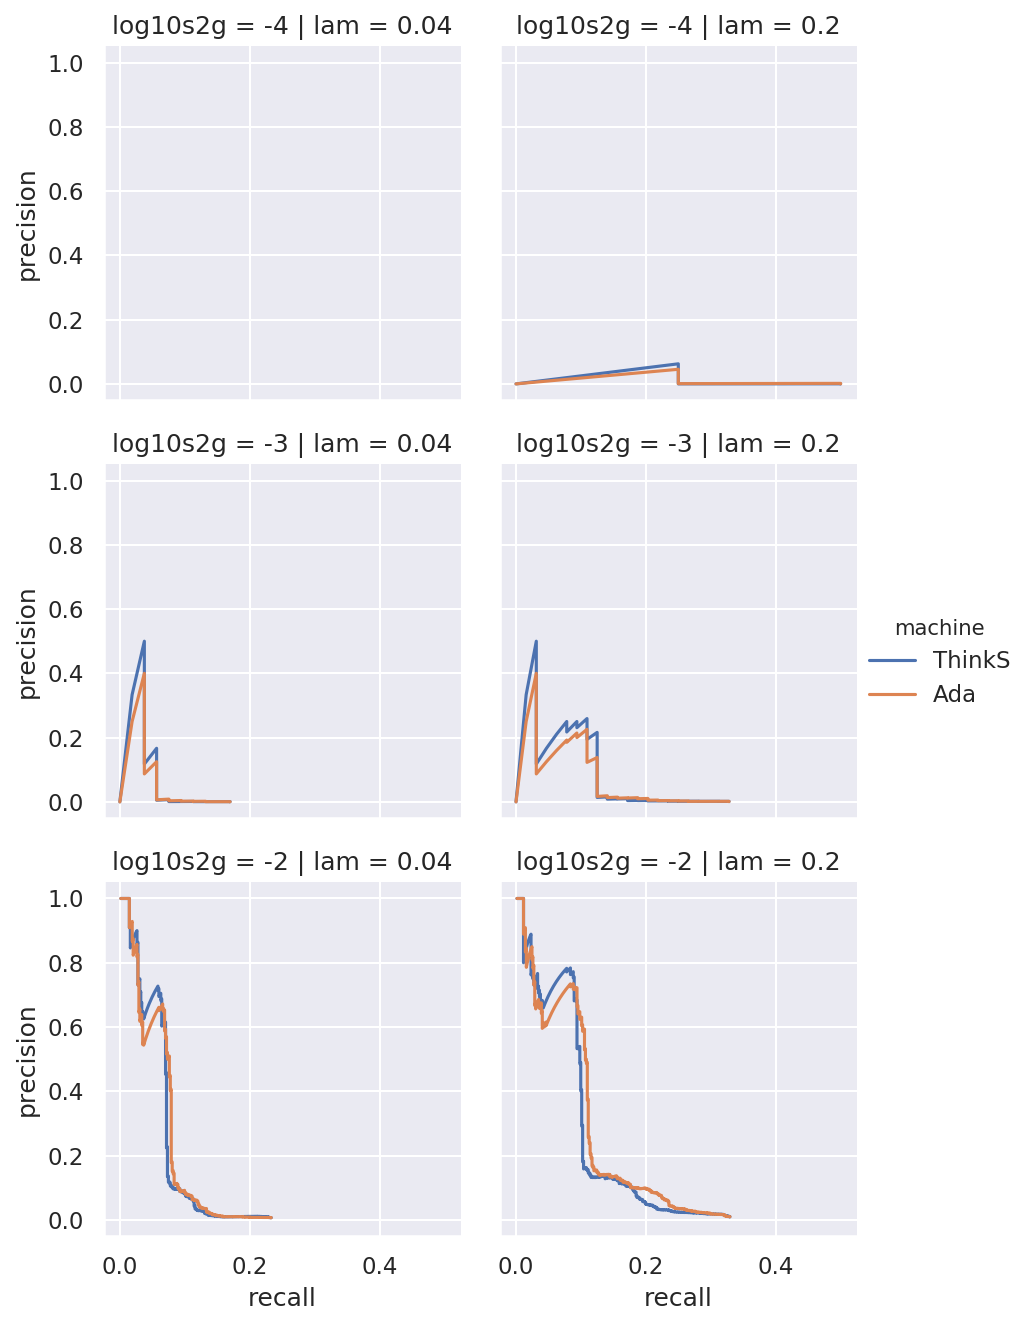

In [407]:
fg = multipr.plotter2(vmc_pr_chr22, sample='mix1')

In [408]:
%connect_info

{
  "shell_port": 58843,
  "iopub_port": 52931,
  "stdin_port": 46975,
  "control_port": 38421,
  "hb_port": 34789,
  "ip": "127.0.0.1",
  "key": "5948d43c-6aae35101b411245715713c8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d1fe04f0-868f-4795-a64d-499560acb6e5.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
